In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2

from statistics import mean
from sklearn import metrics
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [67]:
import pickle

In [68]:
with open('clean_df.pkl', 'rb') as file:
    clean_df = pickle.load(file)

In [69]:
with open('stop_words.pkl', 'rb') as file:
    stop_words = pickle.load(file)

In [86]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w not in stop_words]
    
    return(" ".join(x))

clean_df_l = pd.DataFrame(clean_df, columns=['Phrase_3'])

clean_df_l['lemmed_phrase'] = clean_df_l.Phrase_3.apply(lemmatize_text)

In [87]:
clean_df_use = pd.merge(clean_df_l, clean_df[["Sentiment"]], how='inner', left_index=True,
                     right_index=True,)

In [88]:
X = clean_df_use["lemmed_phrase"]
y = clean_df_use["Sentiment"]

In [73]:
y.value_counts(normalize=True)

3    0.272567
1    0.259086
2    0.192497
4    0.150059
0    0.125791
Name: Sentiment, dtype: float64

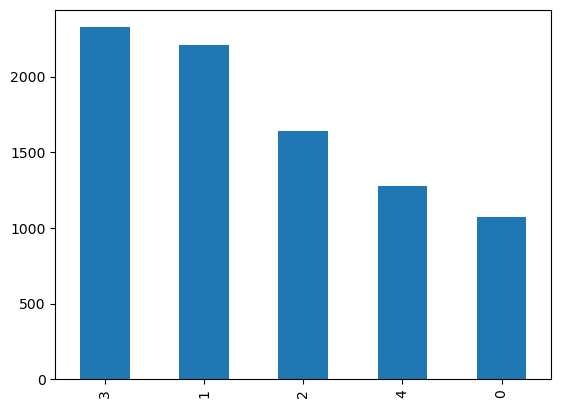

In [85]:
y.value_counts().plot(kind="bar");

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                   stratify=y)

## Multinomial

In [113]:
pipe_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [126]:
pipe_params = {
    'cvec__max_features' : [50000],
    'cvec__min_df' : [1,2,3],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'mnb__alpha': [0.01, 0.1, 1.0]
}

In [127]:
gs_mnb = GridSearchCV(pipe_mnb, 
                  pipe_params, 
                  cv = 5)

In [128]:
gs_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [50000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'mnb__alpha': [0.01, 0.1, 1.0]})

In [129]:
print(gs_mnb.score(X_train,y_train))
print(gs_mnb.score(X_test,y_test))

0.9595122713772081
0.3984997655883732


## Logistic Regression

In [130]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear',max_iter=5000))
])

In [138]:
pipe_params = {
    'cvec__max_features' : [50000],
    'cvec__min_df' : [1,2,3],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
}

In [139]:
gs_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [140]:
gs_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(max_iter=5000,
                                                             solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [50000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [141]:
print(gs_logr.score(X_train,y_train))
print(gs_logr.score(X_test,y_test))

0.3828357042363608
0.29582747304266294


## KNN

In [142]:
pipe_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [143]:
pipe_params = {
    'cvec__max_features' : [50000],
    'cvec__min_df' : [1,2,3],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
}

In [144]:
gs_knn = GridSearchCV(pipe_knn, 
                  pipe_params, 
                  cv = 5)

In [145]:
gs_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [50000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [146]:
print(gs_knn.score(X_train,y_train))
print(gs_knn.score(X_test,y_test))

0.356104423948726
0.2648851383028598


## Random Forest

In [101]:
cv = CountVectorizer(min_df=2)
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [102]:
rf = RandomForestClassifier()

In [103]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [104]:
print(gs_dt.score(X_train_cv,y_train))
print(gs_dt.score(X_test_cv,y_test))

0.9970298577458183
0.369901547116737


Models for Multinomial and LogReg are very weak.
<br>Model for Random Forest is severely overfit.

## Evaluating results

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

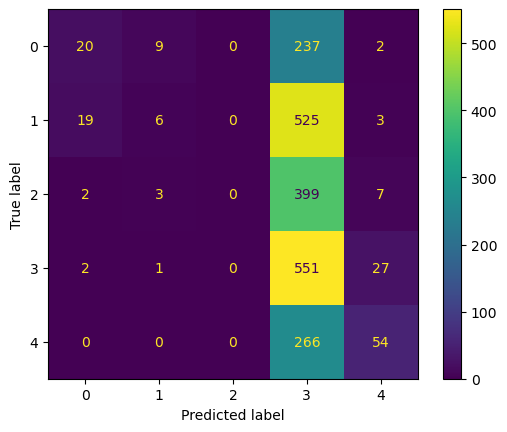

In [159]:
preds = gs_logr.predict(X_test)

cm = confusion_matrix(y_test, preds, labels=gs_logr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gs_logr.classes_)
disp.plot();

This is a really weak model with minimal predictive power. The RNN workbook has additional attempts to improve the model, as well as final outcomes.